In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import joblib
from datetime import datetime
from sklearn.neural_network import MLPClassifier
import os
from sklearn.metrics import confusion_matrix, cohen_kappa_score, mean_squared_error, r2_score
from sklearn.metrics import make_scorer
from catboost import CatBoostClassifier

# df = pd.read_excel('../data/pitcher_prediction_dataset/pitcher_prediction_dataset_V4.xlsx')
df = pd.read_csv('../data/pitcher_prediction_dataset/pitcher_prediction_dataset_V4.csv', low_memory=False)
print("Finished Loading Data")
df = df[~df['pitch_type'].isin([15, 16,17])]
cols_to_convert = [
    "pitch_type", "release_speed_level", "release_pos_x_level", "release_pos_y_level", "release_pos_z_level",
    "pfx_x_level", "pfx_z_level", "vx0_level", "vy0_level", "vz0_level", "ax_level", "ay_level", "az_level",
    "effective_speed_level", "release_spin_rate_level", "release_extension_level", "plate_x_level", "plate_z_level",
    "p_throws_L", "p_throws_R", "type_B", "type_S", "type_X", "pitch_type_CH", "pitch_type_CS", "pitch_type_CU",
    "pitch_type_EP", "pitch_type_FA", "pitch_type_FC", "pitch_type_FF", "pitch_type_FO", "pitch_type_FS",
    "pitch_type_KC", "pitch_type_KN", "pitch_type_PO", "pitch_type_SI", "pitch_type_SL", "pitch_type_ST",
    "pitch_type_SV", "B_release_speed_level", "B_release_pos_x_level", "B_release_pos_y_level", 
    "B_release_pos_z_level", "B_pfx_x_level", "B_pfx_z_level", "B_vx0_level", "B_vy0_level", "B_vz0_level",
    "B_ax_level", "B_ay_level", "B_az_level", "B_effective_speed_level", "B_release_spin_rate_level", 
    "B_release_extension_level", "B_plate_x_level", "B_plate_z_level", "B_p_throws_L", "B_p_throws_R",
    "B_type_B", "B_type_S", "B_type_X", "B_pitch_type_CH", "B_pitch_type_CS", "B_pitch_type_CU", 
    "B_pitch_type_EP", "B_pitch_type_FA", "B_pitch_type_FC", "B_pitch_type_FF", "B_pitch_type_FO", 
    "B_pitch_type_FS", "B_pitch_type_KC", "B_pitch_type_KN", "B_pitch_type_PO", "B_pitch_type_SI", 
    "B_pitch_type_SL", "B_pitch_type_ST", "B_pitch_type_SV", "balls", "strikes", "on_3b", "on_2b", "on_1b", 
    "outs_when_up", "inning", "inning_topbot", "home_score", "away_score", "at_bat_number", "pitch_number", 
    "game_pk", "delta_pitcher_run_exp", "stand", "pitcher", "api_break_z_with_gravity_level", 
    "api_break_x_arm_level", "api_break_x_batter_in_level", "arm_angle_level", "B_api_break_z_with_gravity_level", 
    "B_api_break_x_arm_level", "B_api_break_x_batter_in_level", "B_arm_angle_level", "if_fielding_alignment", 
    "of_fielding_alignment", "home_score_diff", "home_win_exp", "age_pit", "n_thruorder_pitcher", 
    "n_priorpa_thisgame_player_at_bat", "age_bat", "pitcher_days_since_prev_game", "prev_pitch_type_1", 
    "prev_delta_pitcher_run_exp_1", "prev_pitch_type_2", "prev_delta_pitcher_run_exp_2", "prev_pitch_type_3", 
    "prev_delta_pitcher_run_exp_3", "prev_pitch_type_4", "prev_delta_pitcher_run_exp_4", "prev_pitch_type_5", 
    "prev_delta_pitcher_run_exp_5"
]

df['prev_delta_pitcher_run_exp_1'] = df['prev_delta_pitcher_run_exp_1'].fillna(0)
df['prev_delta_pitcher_run_exp_2'] = df['prev_delta_pitcher_run_exp_2'].fillna(0)
df['prev_delta_pitcher_run_exp_3'] = df['prev_delta_pitcher_run_exp_3'].fillna(0)
df['prev_delta_pitcher_run_exp_4'] = df['prev_delta_pitcher_run_exp_4'].fillna(0)
df['prev_delta_pitcher_run_exp_5'] = df['prev_delta_pitcher_run_exp_5'].fillna(0)
df = df.dropna()

for col in cols_to_convert:
    if df[col].map(type).eq(str).any():
        df[col] = df[col].str.extract('([0-9.-]+)', expand=False)
        df[col] = df[col].astype(float)


df = df.dropna()
df = df.drop(columns=['pitcher', 'game_pk', "delta_pitcher_run_exp"])


X = df.drop(columns=['pitch_type'])
y = df['pitch_type']
# print(y.sort_values())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Finished standardizing data")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
print("Finished Splitting data")

Finished Loading Data
Finished standardizing data
Finished Splitting data


In [2]:
# param_grid = {
#     'iterations': [100, 200],
#     'depth': [4, 6, 8],
#     'learning_rate': [0.01, 0.1],
# }
param_grid = {
    'iterations': [100, 200, 500],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    # 'l2_leaf_reg': [1, 3, 5, 7],
    # 'bagging_temperature': [0, 1, 2],
    # 'border_count': [32, 64, 128],
    # 'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
}

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    # 'activation': ['relu', 'tanh', 'logistic'],
    # 'solver': ['adam', 'sgd'],
    # 'learning_rate': ['constant', 'adaptive'],
    'max_iter': [500, 1000],
}

pca_components_list = [70,90, None]
pca_accuracies = []
best_accuracy = 0
best_model = None
best_pca_components = 0

print("Starting PCA & GridSearchCV")

for n_components in pca_components_list:
    print('n_components:', n_components)
    if n_components is not None:
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
    else:
        X_train_pca, X_test_pca = X_train, X_test

    mlp_model = MLPClassifier(random_state=42)
    grid_search = GridSearchCV(mlp_model, param_grid, cv=2, scoring='accuracy', n_jobs=1, verbose=3)

    grid_search.fit(X_train_pca, y_train)

    y_pred = grid_search.best_estimator_.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    pca_accuracies.append((n_components, accuracy))

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = grid_search.best_estimator_
        best_pca_components = n_components



Starting PCA & GridSearchCV
n_components: 70
Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END hidden_layer_sizes=(50,), max_iter=500;, score=0.562 total time= 7.8min
[CV 2/2] END hidden_layer_sizes=(50,), max_iter=500;, score=0.565 total time= 9.9min
[CV 1/2] END hidden_layer_sizes=(50,), max_iter=1000;, score=0.562 total time= 6.0min
[CV 2/2] END hidden_layer_sizes=(50,), max_iter=1000;, score=0.565 total time= 8.6min
[CV 1/2] END hidden_layer_sizes=(100,), max_iter=500;, score=0.562 total time=11.0min
[CV 2/2] END hidden_layer_sizes=(100,), max_iter=500;, score=0.562 total time=13.0min
[CV 1/2] END hidden_layer_sizes=(100,), max_iter=1000;, score=0.562 total time=11.0min
[CV 2/2] END hidden_layer_sizes=(100,), max_iter=1000;, score=0.562 total time=13.4min
[CV 1/2] END hidden_layer_sizes=(50, 50), max_iter=500;, score=0.564 total time=14.9min
[CV 2/2] END hidden_layer_sizes=(50, 50), max_iter=500;, score=0.565 total time=18.4min
[CV 1/2] END hidden_layer_sizes

In [3]:
os.makedirs('../model', exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f"../model/best_mlp_pitcher_agent_prediction_model_{timestamp}.joblib"

joblib.dump({
    'model': best_model,
    'pca': pca if best_pca_components is not None else None,
    'n_components': best_pca_components,
    'accuracy': best_accuracy
}, model_filename)

print(f"Model saved to {model_filename}")

Model saved to ../model/best_mlp_pitcher_agent_prediction_model_20250112_125305.joblib


In [4]:
# for n_components in pca_components_list:
#     print('n_components:', n_components)
#     if n_components is not None:
#         pca = PCA(n_components=n_components)
#         X_train_pca = pca.fit_transform(X_train)
#         X_test_pca = pca.transform(X_test)
#     else:
#         X_train_pca, X_test_pca = X_train, X_test

#     cat_model = CatBoostClassifier(eval_metric='MultiClass', random_state=42, task_type='GPU', verbose=0)
#     grid_search = GridSearchCV(cat_model, param_grid, cv=2, scoring='accuracy', n_jobs=1)

#     grid_search.fit(X_train_pca, y_train)

#     y_pred = grid_search.best_estimator_.predict(X_test_pca)
#     accuracy = accuracy_score(y_test, y_pred)
#     pca_accuracies.append((n_components, accuracy))

#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         best_model = grid_search.best_estimator_
#         best_pca_components = n_components


# # os.makedirs('saved_models', exist_ok=True)
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# model_filename = f"../model/best_catboost_pitcher_agent_prediction_model_{timestamp}.joblib"
# model_folder = os.path.join('..', 'model')
# os.makedirs(model_folder, exist_ok=True)

# model_filename = f"best_catboost_pitcher_agent_prediction_model_{timestamp}.joblib"
# file_path = os.path.join(model_folder, model_filename)

# joblib.dump({
#     'model': best_model,
#     'pca': pca if best_pca_components is not None else None,
#     'n_components': best_pca_components,
#     'accuracy': best_accuracy
# }, file_path)

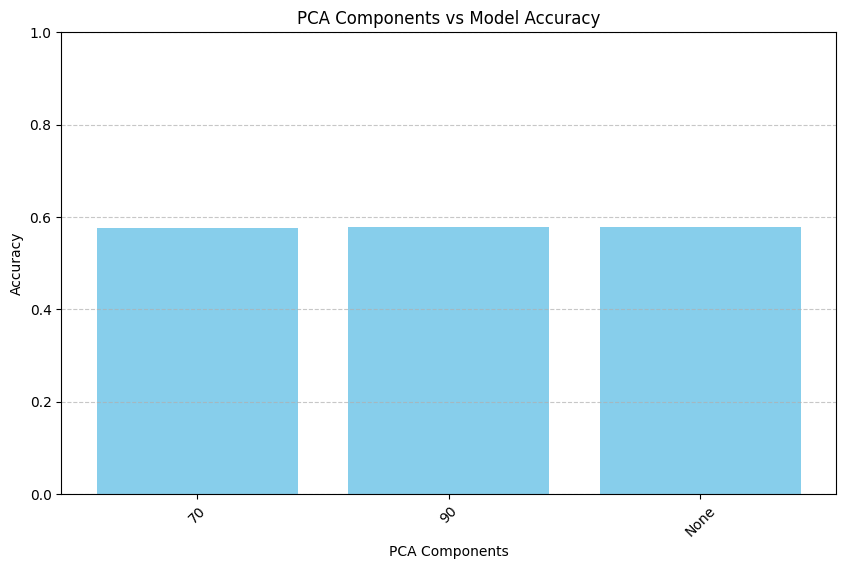

AttributeError: 'MLPClassifier' object has no attribute 'feature_importances_'

In [5]:
components, accuracies = zip(*pca_accuracies)
components = ['None' if c is None else str(c) for c in components]

plt.figure(figsize=(10, 6))
plt.bar(components, accuracies, color='skyblue')
plt.xlabel('PCA Components')
plt.ylabel('Accuracy')
plt.title('PCA Components vs Model Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# feature_importances = best_model.feature_importances_

# if best_pca_components is None:
#     features = X.columns
# else:
#     features = [f'PC{i+1}' for i in range(best_pca_components)]

# plt.figure(figsize=(12, 6))
# plt.barh(features, feature_importances, color='coral')
# plt.xlabel('Importance')
# plt.title('Feature Importance (Best Model)')
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.show()


print(f"Best accuracy: {best_accuracy:.4f} with PCA components: {best_pca_components}")

model_folder = os.path.join('..', 'model')
file_path = os.path.join(model_folder, model_filename)

saved_model = joblib.load(file_path)
loaded_model = saved_model['model']
loaded_pca = saved_model['pca']

if loaded_pca is not None:
    X_test_pca = loaded_pca.transform(X_test)
else:
    X_test_pca = X_test

y_pred_loaded = loaded_model.predict(X_test_pca)
loaded_accuracy = accuracy_score(y_test, y_pred_loaded)
print(f"Accuracy of loaded model: {loaded_accuracy:.4f}")

model_folder = os.path.join('..', 'model')
file_path = os.path.join(model_folder, model_filename)

saved_model = joblib.load(file_path)
loaded_model = saved_model['model']
loaded_pca = saved_model['pca']

if loaded_pca is not None:
    X_test_pca = loaded_pca.transform(X_test)
else:
    X_test_pca = X_test

y_pred_loaded = loaded_model.predict(X_test_pca)
loaded_accuracy = accuracy_score(y_test, y_pred_loaded)
print(f"Accuracy of loaded model: {loaded_accuracy:.4f}")


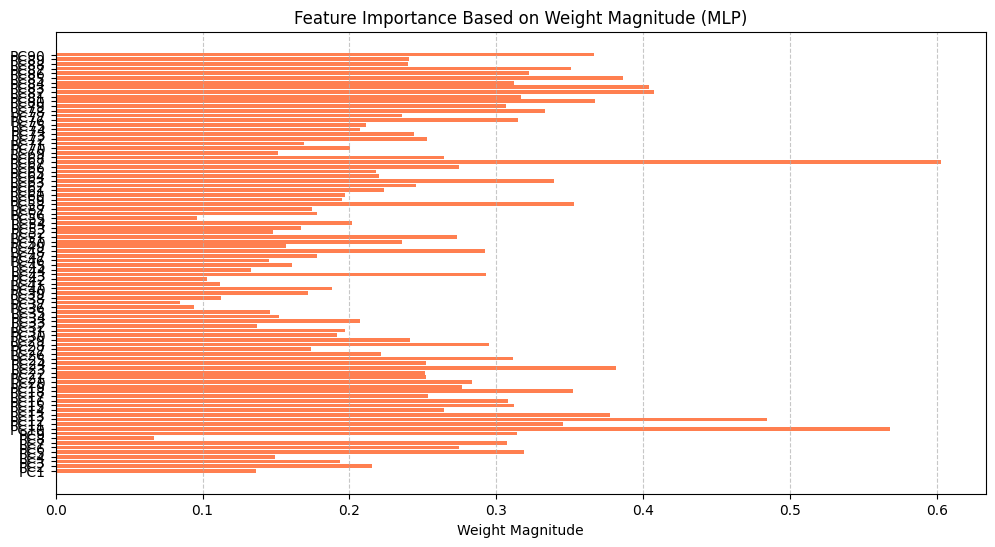

In [6]:
coefs = best_model.coefs_[0]  # First layer weights
feature_importance = np.mean(np.abs(coefs), axis=1)

features = X.columns if best_pca_components is None else [f'PC{i+1}' for i in range(best_pca_components)]
plt.figure(figsize=(12, 6))
plt.barh(features, feature_importance, color='coral')
plt.xlabel('Weight Magnitude')
plt.title('Feature Importance Based on Weight Magnitude (MLP)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


In [2]:
param_grid = {
    'iterations': [100, 200, 500],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    # 'l2_leaf_reg': [1, 3, 5, 7],
    # 'bagging_temperature': [0, 1, 2],
    # 'border_count': [32, 64, 128],
    # 'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
}

pca_components_list = [70,90,None]
pca_accuracies = []
best_accuracy = 0
best_model = None
best_pca_components = 0

for n_components in pca_components_list:
    print('n_components:', n_components)
    if n_components is not None:
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
    else:
        X_train_pca, X_test_pca = X_train, X_test

    cat_model = CatBoostClassifier(eval_metric='MultiClass', random_state=42, task_type='GPU', verbose=0)
    grid_search = GridSearchCV(cat_model, param_grid, cv=2, scoring='accuracy', n_jobs=1)

    grid_search.fit(X_train_pca, y_train)

    y_pred = grid_search.best_estimator_.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    pca_accuracies.append((n_components, accuracy))

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = grid_search.best_estimator_
        best_pca_components = n_components

n_components: 70
n_components: 90
n_components: None


None


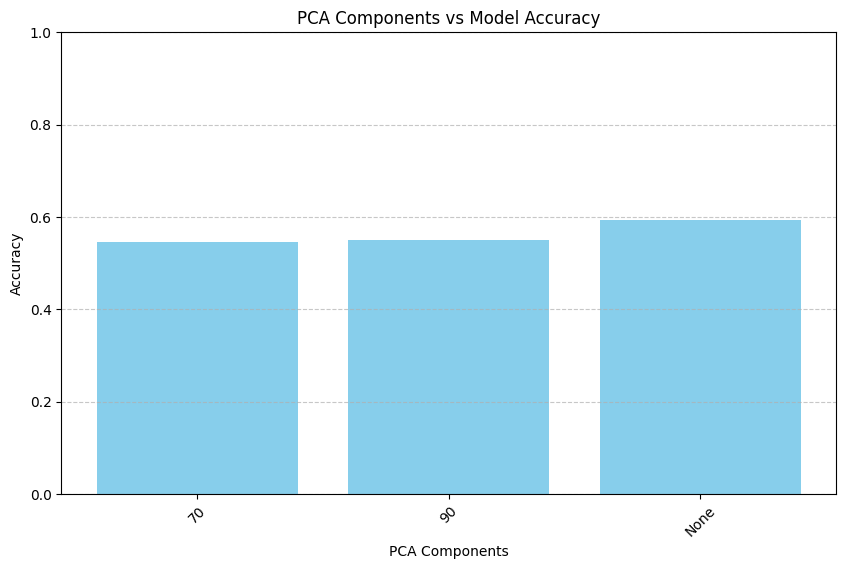

In [3]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f"../model/best_catboost_batter_agent_prediction_model_{timestamp}.joblib"
model_folder = os.path.join('..', 'model')
os.makedirs(model_folder, exist_ok=True)

model_filename = f"best_catboost_event_agent_prediction_model_{timestamp}.joblib"
file_path = os.path.join(model_folder, model_filename)

print(best_pca_components)
pca = PCA(n_components=best_pca_components)
pca.fit_transform(X_train)
joblib.dump({
    'model': best_model,
    'pca': pca if best_pca_components is not None else None,
    'n_components': best_pca_components,
    'accuracy': best_accuracy
}, file_path)



components, accuracies = zip(*pca_accuracies)
components = ['None' if c is None else str(c) for c in components]

plt.figure(figsize=(10, 6))
plt.bar(components, accuracies, color='skyblue')
plt.xlabel('PCA Components')
plt.ylabel('Accuracy')
plt.title('PCA Components vs Model Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


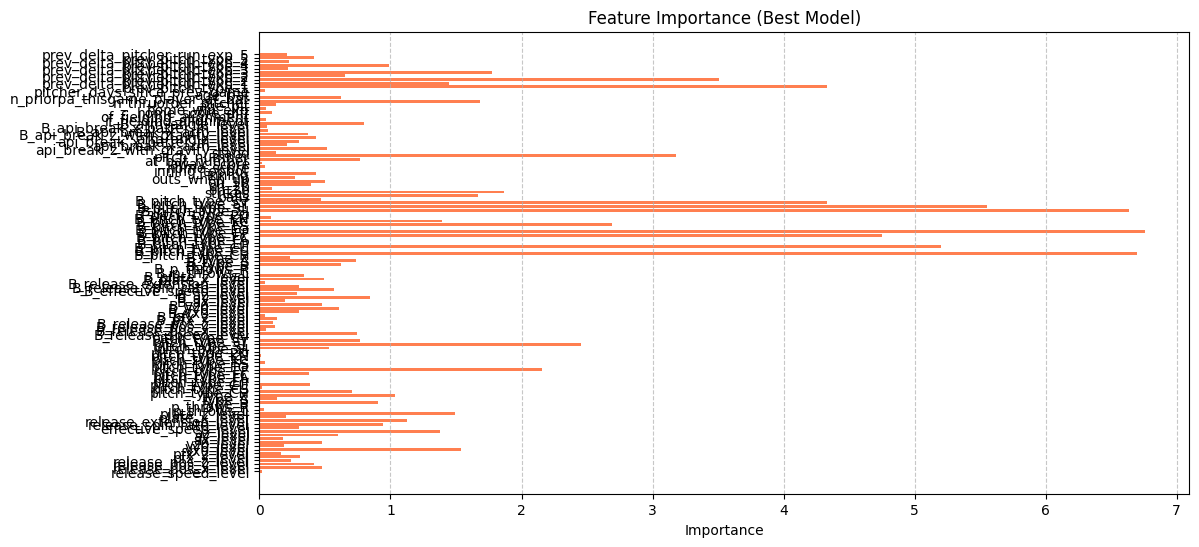

Best accuracy: 0.5940 with PCA components: None
Accuracy of loaded model: 0.5940


In [4]:
feature_importances = best_model.feature_importances_

if best_pca_components is None:
    features = X.columns
else:
    features = [f'PC{i+1}' for i in range(best_pca_components)]

plt.figure(figsize=(12, 6))
plt.barh(features, feature_importances, color='coral')
plt.xlabel('Importance')
plt.title('Feature Importance (Best Model)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


print(f"Best accuracy: {best_accuracy:.4f} with PCA components: {best_pca_components}")


saved_model = joblib.load(file_path)
loaded_model = saved_model['model']
loaded_pca = saved_model['pca']

if loaded_pca is not None:
    X_test_pca = loaded_pca.transform(X_test)
else:
    X_test_pca = X_test

y_pred_loaded = loaded_model.predict(X_test_pca)
loaded_accuracy = accuracy_score(y_test, y_pred_loaded)
print(f"Accuracy of loaded model: {loaded_accuracy:.4f}")